In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import talib
import matplotlib.pyplot as plt
import copy

from backtesting.lib import crossover
from backtesting import Backtest, Strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
def get_historical_data(ticker, period):
    d = yf.Ticker(ticker)
    df = d.history(period=period)
    df.columns = df.columns.str.lower()
    df.columns = pd.Series(df.columns).str.capitalize().values
    return df.dropna()

In [3]:
_df = get_historical_data('2454.TW', '5y')
_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,185.476041,185.476041,182.041299,182.470642,4760000,0.0,0
2017-05-09,181.182624,182.470652,178.606567,178.606567,5119000,0.0,0
2017-05-10,180.323926,181.182611,176.889184,179.465240,4413000,0.0,0
2017-05-11,179.035904,184.188016,179.035904,183.329330,6470000,0.0,0
2017-05-12,183.329318,184.188004,181.611948,184.188004,4692000,0.0,0
...,...,...,...,...,...,...,...
2022-04-29,850.000000,850.000000,830.000000,830.000000,6664286,0.0,0
2022-05-03,830.000000,833.000000,808.000000,820.000000,8296427,0.0,0
2022-05-04,829.000000,835.000000,825.000000,829.000000,3551729,0.0,0


In [4]:
tw_df = get_historical_data('^TWII', '5y')
tw_df

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2017-05-08,9934.129883,9964.860352,9900.070312,9937.250000,1860700,0,0
2017-05-09,9967.009766,10001.940430,9899.080078,9915.480469,2425200,0,0
2017-05-10,9935.219727,9971.980469,9932.169922,9968.320312,1972100,0,0
2017-05-11,9968.509766,10018.790039,9964.299805,10001.480469,2145200,0,0
2017-05-12,9981.769531,10008.250000,9961.370117,9986.820312,1833700,0,0
...,...,...,...,...,...,...,...
2022-04-29,16599.839844,16663.660156,16521.939453,16592.179688,3416300,0,0
2022-05-03,16593.210938,16604.869141,16465.990234,16498.900391,2457700,0,0
2022-05-04,16531.369141,16617.060547,16514.300781,16565.830078,2630000,0,0


### BBands w/ RSI

In [5]:
talib.MA_Type.T3

8

In [104]:
class BBands_RSI(Strategy):
    
    """
    Functions:
        def buy(self, *, size=.9999, limit=None, stop=None, sl=None, tp=None)
        def sell(self, *, size=.9999, limit=None, stop=None, sl=None, tp=None)
        def close(self, portion=1.0)
    
    Parameters:
        MA_Type: 0=SMA, 1=EMA, 2=WMA, 3=DEMA, 4=TEMA, 5=TRIMA, 6=KAMA, 7=MAMA, 8=T3 (Default=SMA)
    """
    
    matype = 8
    
    # n1: bbands (default: 5), n2:rsi (default: 14)
    n1 = 5
    n2 = 14
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        upper, middle, lower = talib.BBANDS(close, timeperiod=self.n1, matype=self.matype)
        rsi = talib.RSI(close, timeperiod=self.n2)
        
        # Precompute signal
        signal_long = (rsi.shift() > 50) & (rsi.shift() < 70) & (close < middle.shift())
        signal_short = (rsi.shift() < 50) & (rsi.shift() > 30) & (close > upper.shift())

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot
        self.I(lambda x: upper, 'upper')
        self.I(lambda x: lower, 'lower')
        self.I(lambda x: rsi, 'RSI')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]
        price = self.data.Close[-1]
        
        # long/short SL and TP
        long_sl = price * 0.90
        long_tp = price * 1.10
        short_sl = price * 1.10
        short_tp = price * 0.90

        if entry_size > 0:
            self.buy(sl = long_sl, tp = long_tp)
            # self.buy()
        elif entry_size < 0:
            self.sell(sl = short_sl, tp = short_tp)
            
            # for trade in self.trades:
            #     trade.close()
        """      
        # tsl
        for trade in self.trades: 
            # print(trade)
        
            if trade.is_long: 
                trade.sl = max(trade.sl or -np.inf, 
                            self.data["Close"][-1] * 0.98) 
            else: # short
                trade.sl = min(trade.sl or np.inf, 
                            self.data["Close"][-1] * 1.02)
        """

In [105]:
bt_bb_rsi = Backtest(_df, BBands_RSI, cash=100000, commission=0.001425, trade_on_close=True)
result_bb_rsi = bt_bb_rsi.run()
bt_bb_rsi.plot()

Row(id='43719', ...)

<AxesSubplot:>

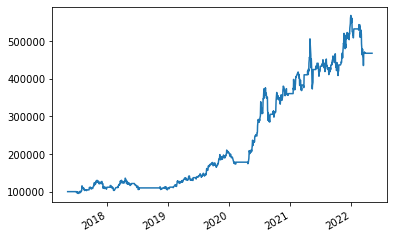

In [51]:
result_bb_rsi._equity_curve.Equity.plot()

In [54]:
print(result_bb_rsi)

Start                     2017-05-08 00:00:00
End                       2022-05-06 00:00:00
Duration                   1824 days 00:00:00
Exposure Time [%]                   72.577997
Equity Final [$]                467844.702169
Equity Peak [$]                 568350.096794
Return [%]                         367.844702
Buy & Hold Return [%]              357.059826
Return (Ann.) [%]                   37.607383
Volatility (Ann.) [%]               44.846113
Sharpe Ratio                         0.838587
Sortino Ratio                        1.865141
Calmar Ratio                         1.429183
Max. Drawdown [%]                    -26.3139
Avg. Drawdown [%]                   -5.982865
Max. Drawdown Duration      356 days 00:00:00
Avg. Drawdown Duration       36 days 00:00:00
# Trades                                   22
Win Rate [%]                        72.727273
Best Trade [%]                      71.437143
Worst Trade [%]                    -12.161369
Avg. Trade [%]                    

In [52]:
result_bb_rsi_2 = bt_bb_rsi.optimize(matype=range(0, 9),
                                     n1=range(5, 20), n2=range(5, 20))
result_bb_rsi_2._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 2025 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/11 [00:00<?, ?it/s]

<Strategy BBands_RSI(matype=6,n1=15,n2=16)>

<AxesSubplot:>

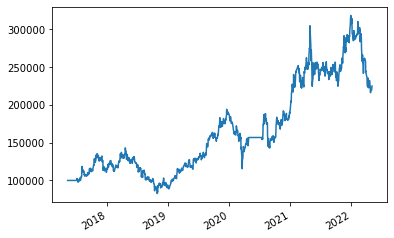

In [53]:
result_bb_rsi_2._equity_curve.Equity.plot()

### RSI w/ EMA

In [11]:
class RSI_EMA(Strategy):
    
    n1 = 20
    n2 = 50
    n3 = 10
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        
        ema1 = talib.EMA(close, timeperiod=self.n1)
        ema2 = talib.EMA(close, timeperiod=self.n2)
        rsi = talib.RSI(close, timeperiod=self.n3)
        
        # compute buy and sell signals (golden cross and death cross)

        # 逆勢.改
        signal_long = (rsi.shift() < 30) & (ema1 > ema2)  # (ema1 > ema2) # ema1.shift() )
        signal_short = (rsi.shift() > 70) & (ema1 < ema2) # (ema1 < ema2) # ema1.shift() )
        
        # combine long and short signals
        signal = signal_long.copy()
        signal[signal_short] = -1
        signal = signal.shift(5)
        
        # plot sma
        self.I(lambda x: ema1, 'ema1')
        self.I(lambda x: ema2, 'ema2')
        self.I(lambda x: rsi, 'RSI')
        
        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')
        
    def next(self):
        super().next()
        
        entry_size = self.signal[-1]
        
        if entry_size > 0:    
            self.buy(size = 0.3) # size: 要用手上多少資金買
#             self.buy()
        elif entry_size < 0: 
#             for trade in self.trades:
#                 trade.close()
            self.sell(size = 1)

In [12]:
bt_rsi_ema = Backtest(_df, RSI_EMA)
result_rsi_ema = bt_rsi_ema.run()
bt_rsi_ema.plot()

Row(id='2561', ...)

<AxesSubplot:>

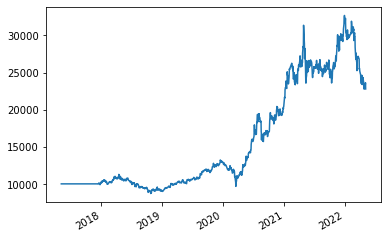

In [13]:
result_rsi_ema._equity_curve.Equity.plot()

In [14]:
result_rsi_ema_2 = bt_rsi_ema.optimize(n1=range(5, 200, 10),
                                       n2=range(5, 200, 10))
result_rsi_ema_2._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/10 [00:00<?, ?it/s]

<Strategy RSI_EMA(n1=45,n2=5)>

<AxesSubplot:>

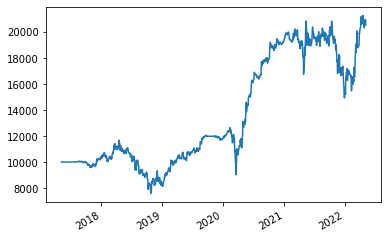

In [15]:
result_rsi_ema_2._equity_curve.Equity.plot()

### MACD

In [16]:
class MACD(Strategy):
    
    short_ema = 12
    long_ema = 26
    
    def init(self):
        super().init()
        
        # Precompute the two moving averages
        close = pd.Series(self.data.Close)
        dif, dea, macd = talib.MACD(close, fastperiod=self.short_ema, slowperiod=self.long_ema)
        
        # Precompute signal
        signal_long = (dif.shift() < macd.shift()) & (dif > macd)
        signal_short = (dif.shift() > macd.shift()) & (dif < macd)

        # combine signal
        signal = signal_long
        signal[signal_short] = -1
        
        # plot
        self.I(lambda x: macd, 'MACD')
        self.I(lambda x: dif, 'DIF')

        # set signal to trade
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()

        entry_size = self.signal[-1]

        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
            for trade in self.trades:
                trade.close()

In [17]:
bt_macd = Backtest(_df, MACD)
result_macd = bt_macd.run()
bt_macd.plot()

Row(id='3561', ...)

<AxesSubplot:>

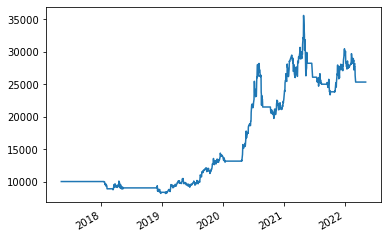

In [18]:
result_macd._equity_curve.Equity.plot()

In [19]:
result_macd_2 = bt_macd.optimize(short_ema=range(5, 200, 10),
                                 long_ema=range(5, 200, 10))
result_macd_2._strategy

/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()
/Users/jesse/miniforge3/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


  0%|          | 0/10 [00:00<?, ?it/s]

<Strategy MACD(short_ema=25,long_ema=105)>

<AxesSubplot:>

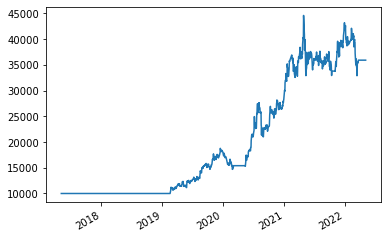

In [20]:
result_macd_2._equity_curve.Equity.plot()